In [1]:
from I3Tray import I3Tray
from icecube import icetray, dataio, dataclasses, simclasses
from icecube.LeptonInjector import weight_hnl_generation, load_generation_weighting_files, weight_hnl_lifetime_framewise
from icecube.LeptonInjector.oscNext_frame_objects_weighting import create_weight_dict
import LeptonWeighter as LW

import numpy as np
import pandas as pd
import os, sys, glob
import matplotlib
import matplotlib.pyplot as plt

from icecube.filterscripts.offlineL2.level2_all_filters import OfflineFilter
from icecube.filterscripts.offlineL2 import SpecialWriter

try: from tqdm import tqdm
except: tqdm = lambda x: x


/cvmfs/icecube.opensciencegrid.org/py3-v4.1.1/RHEL_8_x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Using `import I3Tray` or `from I3Tray import *` is now considered depricated. Please switch to using `from icecube.icetray import I3Tray`
  """Entry point for launching an IPython kernel.
/cvmfs/icecube.opensciencegrid.org/py3-v4.1.1/RHEL_8_x86_64/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<char, std::allocator<char> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/cvmfs/icecube.opensciencegrid.org/py3-v4.1.1/RHEL_8_x86_64/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::allocator<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/cvmfs/

ModuleNotFoundError: No module named 'icecube.LeptonInjector.oscNext_frame_objects_weighting'

In [2]:
mc_dir = "/n/holylfs05/LABS/arguelles_delgado_lab/Lab/HNL_MC/190200/"
level = "L2"
output_filename = f"extracted_info_{level}.npy"

# Let's just grab the first 100 files.
L2_files = sorted(glob.glob(os.path.join(mc_dir, level, "*.i3.zst")))[:100]


In [4]:
print(L2_files)

['/n/holylfs05/LABS/arguelles_delgado_lab/Lab/HNL_MC/190200/L2/1_1.i3.zst', '/n/holylfs05/LABS/arguelles_delgado_lab/Lab/HNL_MC/190200/L2/1_2.i3.zst', '/n/holylfs05/LABS/arguelles_delgado_lab/Lab/HNL_MC/190200/L2/1_3.i3.zst', '/n/holylfs05/LABS/arguelles_delgado_lab/Lab/HNL_MC/190200/L2/1_5.i3.zst']


In [117]:
def read_files(files, nfiles=None):
    passed_filters, MCPESeriesMap, MCPESeriesMap_withNoise, trigger_types, trigger_sources = [], [], [], [], []
    
    if nfiles is None: nfiles = len(files)
    num_frames=0
    num_noisy=0
    # Loop over the files
    for f in tqdm(files):
        i3file = dataio.I3File(f)

        # And loop through frames for this file
        while i3file.more():
            frame = i3file.pop_frame()
            num_frames +=1
            #if frame.Stop != icetray.I3Frame.Physics: continue
            # Variables relevant at Det level
            if not frame.Has("QFilterMask"):
                continue
            
            mask = frame["QFilterMask"]
            for qfilter in mask:
                if trigger.fired:
                    key = trigger.key
                    trigger_types.append(str(dataclasses.TriggerKey.get_type_string(key, key.type)))
                    trigger_sources.append(str(dataclasses.TriggerKey.get_source_string(key, key.source)))
            
            
            # Variables relevant at Det level
            if not frame.Has("MCPESeriesMap_withNoise"):
                continue
            num_noisy +=1
            MCPESeriesMap.append(simclasses.I3MCPESeriesMap(frame["MCPESeriesMap"]))
            MCPESeriesMap_withNoise.append(simclasses.I3MCPESeriesMap(frame["MCPESeriesMap_withNoise"]))

            triggers = frame["I3Triggers"]
            for trigger in triggers:
                if trigger.fired:
                    key = trigger.key
                    trigger_types.append(str(dataclasses.TriggerKey.get_type_string(key, key.type)))
                    trigger_sources.append(str(dataclasses.TriggerKey.get_source_string(key, key.source)))
    print(num_frames)
    print(num_noisy)

    return {"MCPESeriesMap": MCPESeriesMap, "MCPESeriesMap_withNoise": MCPESeriesMap_withNoise, 
                         "trigger_types": trigger_types, "trigger_sources": trigger_sources}


In [118]:
quack = read_files(det_files)

100%|██████████| 6/6 [00:01<00:00,  5.92it/s]

674
555


### How too access info from the pulse series maps (I3MCPESeriesMap)

Assuming you've named your map "map"...

map.keys() will give you the indices of the activated DOMs
map.values() will give you a list of I3MCPE objects. These have the time, # of photoelectrons, and I3ParticleID. We'll use the number of photoelectrons and the time.

The L1 SplitUncleanedInIcePulses should work in much the same way

In [84]:
iteratable=((properties[1,0].itervalues()))

In [89]:
print(next(iteratable))

[[ I3MCPE::
  Time :9898.8
  NPE  :1
  I3ParticleID(214195337436020496, 2659) ]]


In [149]:
from icecube.simclasses import I3CLSimEventStatistics

def read_phot_files(files, nfiles=None):
    if nfiles is None: nfiles = len(files)
    num_frames=0
    num_noisy=0
    casc0_photons, casc0_photons_at_doms, casc0_totalweights, casc1_photons, casc1_photons_at_doms, casc1_totalweights = [],[],[],[],[],[]
            
    # Loop over the files
    for f in tqdm(files):
        i3file = dataio.I3File(f)

        # And loop through frames for this file
        while i3file.more():
            frame = i3file.pop_frame()
            store_photon_information(frame)
            
            if not frame.Has("clsim_stats"):
                print("Not a photon frame")
                continue
            photon_stats=frame["clsim_stats"]     
            mctree = frame["I3MCTree"]
            p_true = mctree.primaries[0]
            p_daughters = mctree.get_daughters(p_true)

            assert len(p_daughters) == 2

            for p_daughter in p_daughters:
                if p_daughter.type == dataclasses.I3Particle.Hadrons:
                    casc0_photons.append(I3CLSimEventStatistics.GetNumberOfPhotonsGeneratedForParticle(photon_stats, p_daughter))
                    casc0_photons_at_doms.append(I3CLSimEventStatistics.GetNumberOfPhotonsAtDOMsForParticle(photon_stats, p_daughter))
                    casc0_totalweights.append(I3CLSimEventStatistics.GetSumOfWeightsPhotonsGeneratedForParticle(photon_stats, p_daughter))      
                else:
                    hnl_true = p_daughter

            hnl_daughters = mctree.get_daughters(hnl_true)
            assert len(hnl_daughters) > 0

            temp_casc1_photons=0
            temp_casc1_photons_at_doms=0
            temp_casc1_photon_weights=0

            for hnl_daughter in hnl_daughters:
                temp_casc1_photons += I3CLSimEventStatistics.GetNumberOfPhotonsGeneratedForParticle(photon_stats, hnl_daughter)
                temp_casc1_photons_at_doms += I3CLSimEventStatistics.GetNumberOfPhotonsAtDOMsForParticle(photon_stats, hnl_daughter)
                temp_casc1_photon_weights += I3CLSimEventStatistics.GetSumOfWeightsPhotonsGeneratedForParticle(photon_stats, hnl_daughter)

            casc1_photons.append(temp_casc1_photons)
            casc1_photons_at_doms.append(temp_casc1_photons_at_doms)
            casc1_totalweights.append(temp_casc1_photon_weights)

        photon_dict = {
            "casc0_photons": casc0_photons,
            "casc0_photons_at_doms": casc0_photons_at_doms,
            "casc0_totalweights": casc0_totalweights,
            "casc1_photons": casc1_photons,
            "casc1_photons_at_doms": casc1_photons_at_doms,
            "casc1_totalweights": casc1_totalweights,
        }
    return photon_dict

In [150]:
phot_files = sorted(glob.glob(os.path.join(mc_dir, "Phot", "*.i3.zst")))[:100]
phot_dict = read_phot_files(phot_files)

  0%|          | 0/7 [00:00<?, ?it/s]

Not a photon frame
Not a photon frame
{'casc0_photons': 14202, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 14202.0}
{'casc0_photons': 3433, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 3433.0}
{'casc0_photons': 185171, 'casc0_photons_at_doms': 6, 'casc0_totalweights': 185171.0}
{'casc0_photons': 7096, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 7096.0}
{'casc0_photons': 36444, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 36444.0}
{'casc0_photons': 20134, 'casc0_photons_at_doms': 4, 'casc0_totalweights': 20134.0}
{'casc0_photons': 8493, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 8493.0}
{'casc0_photons': 16554, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 16554.0}
{'casc0_photons': 131020, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 131020.0}
{'casc0_photons': 33620, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 33620.0}
{'casc0_photons': 69580, 'casc0_photons_at_doms': 7, 'casc0_totalweights': 69580.0}
{'casc0_photons': 23907, 'casc0_photons_

{'casc0_photons': 339140, 'casc0_photons_at_doms': 23, 'casc0_totalweights': 339140.0}
{'casc0_photons': 225055, 'casc0_photons_at_doms': 13, 'casc0_totalweights': 225055.0}
{'casc0_photons': 31947, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 31947.0}
{'casc0_photons': 23276, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 23276.0}
{'casc0_photons': 22393, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 22393.0}
{'casc0_photons': 34999, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 34999.0}
{'casc0_photons': 26402, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 26402.0}
{'casc0_photons': 21155, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 21155.0}
{'casc0_photons': 539717, 'casc0_photons_at_doms': 23, 'casc0_totalweights': 539717.0}
{'casc0_photons': 12584, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 12584.0}
{'casc0_photons': 43455, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 43455.0}
{'casc0_photons': 16636, 'casc0_photons_at_doms': 1, 'casc0_totalwe

{'casc0_photons': 96352, 'casc0_photons_at_doms': 5, 'casc0_totalweights': 96352.0}
{'casc0_photons': 13965, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 13965.0}
{'casc0_photons': 15128, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 15128.0}
{'casc0_photons': 33203, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 33203.0}
{'casc0_photons': 27090, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 27090.0}
{'casc0_photons': 17862, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 17862.0}
{'casc0_photons': 21529, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 21529.0}
{'casc0_photons': 63699, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 63699.0}
{'casc0_photons': 15118, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 15118.0}
{'casc0_photons': 11603, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 11603.0}
{'casc0_photons': 185735, 'casc0_photons_at_doms': 7, 'casc0_totalweights': 185735.0}
{'casc0_photons': 13528, 'casc0_photons_at_doms': 1, 'casc0_totalweights':

{'casc0_photons': 17620, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 17620.0}
{'casc0_photons': 15910, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 15910.0}
{'casc0_photons': 19775, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 19775.0}
{'casc0_photons': 13026, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 13026.0}
{'casc0_photons': 109875, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 109875.0}
{'casc0_photons': 11078, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 11078.0}
{'casc0_photons': 18686, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 18686.0}
{'casc0_photons': 30941, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 30941.0}
{'casc0_photons': 17785, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 17785.0}
{'casc0_photons': 198299, 'casc0_photons_at_doms': 5, 'casc0_totalweights': 198299.0}
{'casc0_photons': 28703, 'casc0_photons_at_doms': 4, 'casc0_totalweights': 28703.0}
{'casc0_photons': 21099, 'casc0_photons_at_doms': 0, 'casc0_totalweights

{'casc0_photons': 20697, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 20697.0}
{'casc0_photons': 11602, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 11602.0}
{'casc0_photons': 33424, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 33424.0}
{'casc0_photons': 25975, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 25975.0}
{'casc0_photons': 31043, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 31043.0}
{'casc0_photons': 27884, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 27884.0}
{'casc0_photons': 350076, 'casc0_photons_at_doms': 10, 'casc0_totalweights': 350076.0}
{'casc0_photons': 32033, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 32033.0}
{'casc0_photons': 736930, 'casc0_photons_at_doms': 11, 'casc0_totalweights': 736930.0}
{'casc0_photons': 1171816, 'casc0_photons_at_doms': 9, 'casc0_totalweights': 1171816.0}
{'casc0_photons': 140859, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 140859.0}
{'casc0_photons': 9727651, 'casc0_photons_at_doms': 256, 'casc0_

{'casc0_photons': 24723, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 24723.0}
{'casc0_photons': 6435, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 6435.0}
{'casc0_photons': 532524, 'casc0_photons_at_doms': 9, 'casc0_totalweights': 532524.0}
{'casc0_photons': 28212, 'casc0_photons_at_doms': 5, 'casc0_totalweights': 28212.0}
{'casc0_photons': 1450473, 'casc0_photons_at_doms': 48, 'casc0_totalweights': 1450473.0}
{'casc0_photons': 12748, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 12748.0}
{'casc0_photons': 28419, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 28419.0}
{'casc0_photons': 134945, 'casc0_photons_at_doms': 10, 'casc0_totalweights': 134945.0}
{'casc0_photons': 29173, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 29173.0}
{'casc0_photons': 182648, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 182648.0}
{'casc0_photons': 9645, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 9645.0}
{'casc0_photons': 0, 'casc0_photons_at_doms': 0, 'casc0_totalweights

{'casc0_photons': 211140, 'casc0_photons_at_doms': 6, 'casc0_totalweights': 211140.0}
{'casc0_photons': 9293, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 9293.0}
{'casc0_photons': 12005, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 12005.0}
{'casc0_photons': 19151, 'casc0_photons_at_doms': 6, 'casc0_totalweights': 19151.0}
{'casc0_photons': 150244, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 150244.0}
{'casc0_photons': 218150, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 218150.0}
{'casc0_photons': 46665, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 46665.0}
{'casc0_photons': 684096, 'casc0_photons_at_doms': 11, 'casc0_totalweights': 684096.0}
{'casc0_photons': 1472397, 'casc0_photons_at_doms': 8, 'casc0_totalweights': 1472397.0}
{'casc0_photons': 31931, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 31931.0}
{'casc0_photons': 137538, 'casc0_photons_at_doms': 37, 'casc0_totalweights': 137538.0}
{'casc0_photons': 8551, 'casc0_photons_at_doms': 1, 'casc0_tot

{'casc0_photons': 17951, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 17951.0}
{'casc0_photons': 33165, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 33165.0}
{'casc0_photons': 28442, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 28442.0}
{'casc0_photons': 46919, 'casc0_photons_at_doms': 5, 'casc0_totalweights': 46919.0}
{'casc0_photons': 31548, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 31548.0}
{'casc0_photons': 25097, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 25097.0}
{'casc0_photons': 14377, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 14377.0}
{'casc0_photons': 18566, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 18566.0}
{'casc0_photons': 18499, 'casc0_photons_at_doms': 4, 'casc0_totalweights': 18499.0}
{'casc0_photons': 20166, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 20166.0}
{'casc0_photons': 21582, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 21582.0}
{'casc0_photons': 46508, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 4

{'casc0_photons': 1264990, 'casc0_photons_at_doms': 66, 'casc0_totalweights': 1264990.0}
{'casc0_photons': 84544, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 84544.0}
{'casc0_photons': 579116, 'casc0_photons_at_doms': 20, 'casc0_totalweights': 579116.0}
{'casc0_photons': 22461, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 22461.0}
{'casc0_photons': 436173, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 436173.0}
{'casc0_photons': 50818, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 50818.0}
{'casc0_photons': 74644, 'casc0_photons_at_doms': 4, 'casc0_totalweights': 74644.0}
{'casc0_photons': 0, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 0.0}
{'casc0_photons': 13439, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 13439.0}
{'casc0_photons': 49919, 'casc0_photons_at_doms': 11, 'casc0_totalweights': 49919.0}
{'casc0_photons': 30431, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 30431.0}
{'casc0_photons': 26577, 'casc0_photons_at_doms': 1, 'casc0_totalweights'

{'casc0_photons': 10779, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 10779.0}
{'casc0_photons': 19748, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 19748.0}
{'casc0_photons': 20307, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 20307.0}
{'casc0_photons': 14870, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 14870.0}
{'casc0_photons': 26375, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 26375.0}
{'casc0_photons': 36346, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 36346.0}
{'casc0_photons': 107515, 'casc0_photons_at_doms': 6, 'casc0_totalweights': 107515.0}
{'casc0_photons': 22539, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 22539.0}
{'casc0_photons': 34187, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 34187.0}
{'casc0_photons': 15429, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 15429.0}
{'casc0_photons': 22980, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 22980.0}
{'casc0_photons': 12920, 'casc0_photons_at_doms': 0, 'casc0_totalweights':

{'casc0_photons': 26567, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 26567.0}
{'casc0_photons': 17153, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 17153.0}
{'casc0_photons': 15885, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 15885.0}
{'casc0_photons': 19358, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 19358.0}
{'casc0_photons': 16318, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 16318.0}
{'casc0_photons': 13220, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 13220.0}
{'casc0_photons': 16561, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 16561.0}
{'casc0_photons': 14496, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 14496.0}
{'casc0_photons': 15011, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 15011.0}
{'casc0_photons': 34793, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 34793.0}
{'casc0_photons': 92093, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 92093.0}
{'casc0_photons': 18275, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 1

{'casc0_photons': 259465, 'casc0_photons_at_doms': 9, 'casc0_totalweights': 259465.0}
{'casc0_photons': 649927, 'casc0_photons_at_doms': 9, 'casc0_totalweights': 649927.0}
{'casc0_photons': 4846572, 'casc0_photons_at_doms': 148, 'casc0_totalweights': 4846572.0}
{'casc0_photons': 77491, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 77491.0}
{'casc0_photons': 58165, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 58165.0}
{'casc0_photons': 97604, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 97604.0}
{'casc0_photons': 22752, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 22752.0}
{'casc0_photons': 70163, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 70163.0}
{'casc0_photons': 29293, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 29293.0}
{'casc0_photons': 30329, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 30329.0}
{'casc0_photons': 10640, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 10640.0}
{'casc0_photons': 17512, 'casc0_photons_at_doms': 1, 'casc0_totalw

{'casc0_photons': 9191, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 9191.0}
{'casc0_photons': 76085, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 76085.0}
{'casc0_photons': 9774, 'casc0_photons_at_doms': 4, 'casc0_totalweights': 9774.0}
{'casc0_photons': 24527, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 24527.0}
{'casc0_photons': 25472, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 25472.0}
{'casc0_photons': 14866, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 14866.0}
{'casc0_photons': 509180, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 509180.0}
{'casc0_photons': 147136, 'casc0_photons_at_doms': 6, 'casc0_totalweights': 147136.0}
{'casc0_photons': 194402, 'casc0_photons_at_doms': 5, 'casc0_totalweights': 194402.0}
{'casc0_photons': 17786, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 17786.0}
{'casc0_photons': 153281, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 153281.0}
{'casc0_photons': 8224, 'casc0_photons_at_doms': 2, 'casc0_totalweights'

 14%|█▍        | 1/7 [00:03<00:22,  3.76s/it]

{'casc0_photons': 206418, 'casc0_photons_at_doms': 6, 'casc0_totalweights': 206418.0}
{'casc0_photons': 470611, 'casc0_photons_at_doms': 8, 'casc0_totalweights': 470611.0}
{'casc0_photons': 33694, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 33694.0}
{'casc0_photons': 10082, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 10082.0}
{'casc0_photons': 41583, 'casc0_photons_at_doms': 10, 'casc0_totalweights': 41583.0}
{'casc0_photons': 169629, 'casc0_photons_at_doms': 4, 'casc0_totalweights': 169629.0}
{'casc0_photons': 52714, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 52714.0}
{'casc0_photons': 101428, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 101428.0}
{'casc0_photons': 71024, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 71024.0}
{'casc0_photons': 14266, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 14266.0}
{'casc0_photons': 7435, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 7435.0}
{'casc0_photons': 45691, 'casc0_photons_at_doms': 2, 'casc0_totalweig

{'casc0_photons': 69580, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 69580.0}
{'casc0_photons': 23907, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 23907.0}
{'casc0_photons': 65482, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 65482.0}
{'casc0_photons': 17847, 'casc0_photons_at_doms': 4, 'casc0_totalweights': 17847.0}
{'casc0_photons': 72088, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 72088.0}
{'casc0_photons': 11871, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 11871.0}
{'casc0_photons': 16636, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 16636.0}
{'casc0_photons': 8009, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 8009.0}
{'casc0_photons': 287573, 'casc0_photons_at_doms': 14, 'casc0_totalweights': 287573.0}
{'casc0_photons': 14884, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 14884.0}
{'casc0_photons': 116526, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 116526.0}
{'casc0_photons': 123119, 'casc0_photons_at_doms': 1, 'casc0_totalweights

{'casc0_photons': 13220, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 13220.0}
{'casc0_photons': 19225, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 19225.0}
{'casc0_photons': 49978, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 49978.0}
{'casc0_photons': 928222, 'casc0_photons_at_doms': 31, 'casc0_totalweights': 928222.0}
{'casc0_photons': 15328, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 15328.0}
{'casc0_photons': 282423, 'casc0_photons_at_doms': 10, 'casc0_totalweights': 282423.0}
{'casc0_photons': 7057, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 7057.0}
{'casc0_photons': 7797, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 7797.0}
{'casc0_photons': 76982, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 76982.0}
{'casc0_photons': 244240, 'casc0_photons_at_doms': 7, 'casc0_totalweights': 244240.0}
{'casc0_photons': 17253, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 17253.0}
{'casc0_photons': 54689, 'casc0_photons_at_doms': 1, 'casc0_totalweights

{'casc0_photons': 48283, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 48283.0}
{'casc0_photons': 118884, 'casc0_photons_at_doms': 5, 'casc0_totalweights': 118884.0}
{'casc0_photons': 202678, 'casc0_photons_at_doms': 11, 'casc0_totalweights': 202678.0}
{'casc0_photons': 8195, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 8195.0}
{'casc0_photons': 182800, 'casc0_photons_at_doms': 4, 'casc0_totalweights': 182800.0}
{'casc0_photons': 56712, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 56712.0}
{'casc0_photons': 94024, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 94024.0}
{'casc0_photons': 19991, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 19991.0}
{'casc0_photons': 29492, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 29492.0}
{'casc0_photons': 18604, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 18604.0}
{'casc0_photons': 38889, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 38889.0}
{'casc0_photons': 22246, 'casc0_photons_at_doms': 1, 'casc0_totalweight

{'casc0_photons': 26779, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 26779.0}
{'casc0_photons': 40939, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 40939.0}
{'casc0_photons': 26304, 'casc0_photons_at_doms': 4, 'casc0_totalweights': 26304.0}
{'casc0_photons': 29646, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 29646.0}
{'casc0_photons': 12859, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 12859.0}
{'casc0_photons': 14356, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 14356.0}
{'casc0_photons': 10057, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 10057.0}
{'casc0_photons': 76679, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 76679.0}
{'casc0_photons': 14903, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 14903.0}
{'casc0_photons': 57663, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 57663.0}
{'casc0_photons': 22782, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 22782.0}
{'casc0_photons': 148177, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 

{'casc0_photons': 24081, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 24081.0}
{'casc0_photons': 30701, 'casc0_photons_at_doms': 4, 'casc0_totalweights': 30701.0}
{'casc0_photons': 9940, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 9940.0}
{'casc0_photons': 26648, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 26648.0}
{'casc0_photons': 29740, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 29740.0}
{'casc0_photons': 13203, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 13203.0}
{'casc0_photons': 18106, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 18106.0}
{'casc0_photons': 28843, 'casc0_photons_at_doms': 5, 'casc0_totalweights': 28843.0}
{'casc0_photons': 664092, 'casc0_photons_at_doms': 13, 'casc0_totalweights': 664092.0}
{'casc0_photons': 26439, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 26439.0}
{'casc0_photons': 30059, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 30059.0}
{'casc0_photons': 12682, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 

{'casc0_photons': 108589, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 108589.0}
{'casc0_photons': 20311, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 20311.0}
{'casc0_photons': 23356, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 23356.0}
{'casc0_photons': 95555, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 95555.0}
{'casc0_photons': 11828, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 11828.0}
{'casc0_photons': 535464, 'casc0_photons_at_doms': 9, 'casc0_totalweights': 535464.0}
{'casc0_photons': 22064, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 22064.0}
{'casc0_photons': 631127, 'casc0_photons_at_doms': 6, 'casc0_totalweights': 631127.0}
{'casc0_photons': 1022570, 'casc0_photons_at_doms': 9, 'casc0_totalweights': 1022570.0}
{'casc0_photons': 246564, 'casc0_photons_at_doms': 8, 'casc0_totalweights': 246564.0}
{'casc0_photons': 12888, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 12888.0}
{'casc0_photons': 11873, 'casc0_photons_at_doms': 1, 'casc0_tota

{'casc0_photons': 18569, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 18569.0}
{'casc0_photons': 19195, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 19195.0}
{'casc0_photons': 20977, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 20977.0}
{'casc0_photons': 85870, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 85870.0}
{'casc0_photons': 31768, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 31768.0}
{'casc0_photons': 29167, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 29167.0}
{'casc0_photons': 37457, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 37457.0}
{'casc0_photons': 40304, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 40304.0}
{'casc0_photons': 7421, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 7421.0}
{'casc0_photons': 27810, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 27810.0}
{'casc0_photons': 166342, 'casc0_photons_at_doms': 14, 'casc0_totalweights': 166342.0}
{'casc0_photons': 14417, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 

{'casc0_photons': 74649, 'casc0_photons_at_doms': 5, 'casc0_totalweights': 74649.0}
{'casc0_photons': 58139, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 58139.0}
{'casc0_photons': 20850, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 20850.0}
{'casc0_photons': 9040, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 9040.0}
{'casc0_photons': 27463, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 27463.0}
{'casc0_photons': 44123, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 44123.0}
{'casc0_photons': 55509, 'casc0_photons_at_doms': 4, 'casc0_totalweights': 55509.0}
{'casc0_photons': 23303, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 23303.0}
{'casc0_photons': 7069, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 7069.0}
{'casc0_photons': 339886, 'casc0_photons_at_doms': 14, 'casc0_totalweights': 339886.0}
{'casc0_photons': 10316, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 10316.0}
{'casc0_photons': 21161, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 21

{'casc0_photons': 84171, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 84171.0}
{'casc0_photons': 21757, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 21757.0}
{'casc0_photons': 47488, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 47488.0}
{'casc0_photons': 25209, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 25209.0}
{'casc0_photons': 14116, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 14116.0}
{'casc0_photons': 31628, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 31628.0}
{'casc0_photons': 28020, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 28020.0}
{'casc0_photons': 7515, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 7515.0}
{'casc0_photons': 24642, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 24642.0}
{'casc0_photons': 28101, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 28101.0}
{'casc0_photons': 45170, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 45170.0}
{'casc0_photons': 14874, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 148

{'casc0_photons': 9685, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 9685.0}
{'casc0_photons': 38366, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 38366.0}
{'casc0_photons': 22231, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 22231.0}
{'casc0_photons': 17037, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 17037.0}
{'casc0_photons': 9819, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 9819.0}
{'casc0_photons': 24605, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 24605.0}
{'casc0_photons': 20998, 'casc0_photons_at_doms': 10, 'casc0_totalweights': 20998.0}
{'casc0_photons': 39829, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 39829.0}
{'casc0_photons': 38759, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 38759.0}
{'casc0_photons': 96463, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 96463.0}
{'casc0_photons': 64426, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 64426.0}
{'casc0_photons': 13661, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 1366

{'casc0_photons': 23922, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 23922.0}
{'casc0_photons': 618201, 'casc0_photons_at_doms': 8, 'casc0_totalweights': 618201.0}
{'casc0_photons': 26265, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 26265.0}
{'casc0_photons': 54755, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 54755.0}
{'casc0_photons': 19317, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 19317.0}
{'casc0_photons': 27623, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 27623.0}
{'casc0_photons': 20888, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 20888.0}
{'casc0_photons': 5790, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 5790.0}
{'casc0_photons': 37767, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 37767.0}
{'casc0_photons': 1228971, 'casc0_photons_at_doms': 33, 'casc0_totalweights': 1228971.0}
{'casc0_photons': 33565, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 33565.0}
{'casc0_photons': 55188, 'casc0_photons_at_doms': 2, 'casc0_totalweight

{'casc0_photons': 106924, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 106924.0}
{'casc0_photons': 41073, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 41073.0}
{'casc0_photons': 260504, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 260504.0}
{'casc0_photons': 12457, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 12457.0}
{'casc0_photons': 11219, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 11219.0}
{'casc0_photons': 136537, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 136537.0}
{'casc0_photons': 6485, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 6485.0}
{'casc0_photons': 13998, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 13998.0}
{'casc0_photons': 16261, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 16261.0}
{'casc0_photons': 152621, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 152621.0}
{'casc0_photons': 280595, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 280595.0}
{'casc0_photons': 35316, 'casc0_photons_at_doms': 3, 'casc0_totalwei

 29%|██▊       | 2/7 [00:06<00:16,  3.36s/it]


{'casc0_photons': 3513963, 'casc0_photons_at_doms': 6, 'casc0_totalweights': 3513963.0}
{'casc0_photons': 24491, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 24491.0}
{'casc0_photons': 25234, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 25234.0}
{'casc0_photons': 61235, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 61235.0}
{'casc0_photons': 26683, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 26683.0}
{'casc0_photons': 9394, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 9394.0}
{'casc0_photons': 83364, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 83364.0}
{'casc0_photons': 101322, 'casc0_photons_at_doms': 4, 'casc0_totalweights': 101322.0}
{'casc0_photons': 11372, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 11372.0}
{'casc0_photons': 12695, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 12695.0}
{'casc0_photons': 39265, 'casc0_photons_at_doms': 5, 'casc0_totalweights': 39265.0}
{'casc0_photons': 56857, 'casc0_photons_at_doms': 0, 'casc0_totalweight

{'casc0_photons': 37066, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 37066.0}
{'casc0_photons': 6925, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 6925.0}
{'casc0_photons': 26235, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 26235.0}
{'casc0_photons': 12324, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 12324.0}
{'casc0_photons': 25426, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 25426.0}
{'casc0_photons': 521578, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 521578.0}
{'casc0_photons': 30047, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 30047.0}
{'casc0_photons': 25186, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 25186.0}
{'casc0_photons': 102376, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 102376.0}
{'casc0_photons': 8794, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 8794.0}
{'casc0_photons': 90965, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 90965.0}
{'casc0_photons': 495661, 'casc0_photons_at_doms': 11, 'casc0_totalweights':

{'casc0_photons': 12424, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 12424.0}
{'casc0_photons': 129911, 'casc0_photons_at_doms': 5, 'casc0_totalweights': 129911.0}
{'casc0_photons': 28959, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 28959.0}
{'casc0_photons': 8372, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 8372.0}
{'casc0_photons': 29387, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 29387.0}
{'casc0_photons': 49547, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 49547.0}
{'casc0_photons': 40680, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 40680.0}
{'casc0_photons': 21236, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 21236.0}
{'casc0_photons': 13440, 'casc0_photons_at_doms': 5, 'casc0_totalweights': 13440.0}
{'casc0_photons': 18005, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 18005.0}
{'casc0_photons': 34745, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 34745.0}
{'casc0_photons': 49959, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 4

{'casc0_photons': 41313, 'casc0_photons_at_doms': 5, 'casc0_totalweights': 41313.0}
{'casc0_photons': 13204, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 13204.0}
{'casc0_photons': 20165, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 20165.0}
{'casc0_photons': 23955, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 23955.0}
{'casc0_photons': 30724, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 30724.0}
{'casc0_photons': 11019, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 11019.0}
{'casc0_photons': 5773, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 5773.0}
{'casc0_photons': 19501, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 19501.0}
{'casc0_photons': 133791, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 133791.0}
{'casc0_photons': 34374, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 34374.0}
{'casc0_photons': 23033, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 23033.0}
{'casc0_photons': 22996, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 2

{'casc0_photons': 6334, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 6334.0}
{'casc0_photons': 12758, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 12758.0}
{'casc0_photons': 14303, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 14303.0}
{'casc0_photons': 145379, 'casc0_photons_at_doms': 8, 'casc0_totalweights': 145379.0}
{'casc0_photons': 21554, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 21554.0}
{'casc0_photons': 92289, 'casc0_photons_at_doms': 4, 'casc0_totalweights': 92289.0}
{'casc0_photons': 35744, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 35744.0}
{'casc0_photons': 199212, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 199212.0}
{'casc0_photons': 90681, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 90681.0}
{'casc0_photons': 70699, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 70699.0}
{'casc0_photons': 57143, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 57143.0}
{'casc0_photons': 17511, 'casc0_photons_at_doms': 2, 'casc0_totalweights':

{'casc0_photons': 41955, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 41955.0}
{'casc0_photons': 49058, 'casc0_photons_at_doms': 4, 'casc0_totalweights': 49058.0}
{'casc0_photons': 17363, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 17363.0}
{'casc0_photons': 189145, 'casc0_photons_at_doms': 10, 'casc0_totalweights': 189145.0}
{'casc0_photons': 11881023, 'casc0_photons_at_doms': 487, 'casc0_totalweights': 11881023.0}
{'casc0_photons': 15940, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 15940.0}
{'casc0_photons': 77852, 'casc0_photons_at_doms': 5, 'casc0_totalweights': 77852.0}
{'casc0_photons': 667467, 'casc0_photons_at_doms': 16, 'casc0_totalweights': 667467.0}
{'casc0_photons': 163612, 'casc0_photons_at_doms': 5, 'casc0_totalweights': 163612.0}
{'casc0_photons': 20712, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 20712.0}
{'casc0_photons': 96119, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 96119.0}
{'casc0_photons': 303424, 'casc0_photons_at_doms': 4, 'casc0

{'casc0_photons': 832758, 'casc0_photons_at_doms': 9, 'casc0_totalweights': 832758.0}
{'casc0_photons': 145678, 'casc0_photons_at_doms': 4, 'casc0_totalweights': 145678.0}
{'casc0_photons': 894557, 'casc0_photons_at_doms': 25, 'casc0_totalweights': 894557.0}
{'casc0_photons': 287659, 'casc0_photons_at_doms': 16, 'casc0_totalweights': 287659.0}
{'casc0_photons': 17772, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 17772.0}
{'casc0_photons': 9258, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 9258.0}
{'casc0_photons': 39496, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 39496.0}
{'casc0_photons': 17388, 'casc0_photons_at_doms': 6, 'casc0_totalweights': 17388.0}
{'casc0_photons': 41529, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 41529.0}
{'casc0_photons': 19357, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 19357.0}
{'casc0_photons': 0, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 0.0}
{'casc0_photons': 41108, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 4

{'casc0_photons': 43496, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 43496.0}
{'casc0_photons': 141001, 'casc0_photons_at_doms': 6, 'casc0_totalweights': 141001.0}
{'casc0_photons': 19453, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 19453.0}
{'casc0_photons': 11470, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 11470.0}
{'casc0_photons': 2241, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 2241.0}
{'casc0_photons': 21560, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 21560.0}
{'casc0_photons': 19271, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 19271.0}
{'casc0_photons': 214015, 'casc0_photons_at_doms': 8, 'casc0_totalweights': 214015.0}
{'casc0_photons': 18017, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 18017.0}
{'casc0_photons': 58214, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 58214.0}
{'casc0_photons': 18066, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 18066.0}
{'casc0_photons': 19017, 'casc0_photons_at_doms': 3, 'casc0_totalweights':

{'casc0_photons': 16216, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 16216.0}
{'casc0_photons': 20161, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 20161.0}
{'casc0_photons': 16018, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 16018.0}
{'casc0_photons': 61281, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 61281.0}
{'casc0_photons': 27548, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 27548.0}
{'casc0_photons': 13987, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 13987.0}
{'casc0_photons': 50523, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 50523.0}
{'casc0_photons': 6798, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 6798.0}
{'casc0_photons': 69607, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 69607.0}
{'casc0_photons': 15909, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 15909.0}
{'casc0_photons': 46713, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 46713.0}
{'casc0_photons': 17464, 'casc0_photons_at_doms': 7, 'casc0_totalweights': 174

{'casc0_photons': 16253, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 16253.0}
{'casc0_photons': 5375, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 5375.0}
{'casc0_photons': 122476, 'casc0_photons_at_doms': 6, 'casc0_totalweights': 122476.0}
{'casc0_photons': 53448, 'casc0_photons_at_doms': 9, 'casc0_totalweights': 53448.0}
{'casc0_photons': 43981, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 43981.0}
{'casc0_photons': 338353, 'casc0_photons_at_doms': 19, 'casc0_totalweights': 338353.0}
{'casc0_photons': 0, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 0.0}
{'casc0_photons': 0, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 0.0}
{'casc0_photons': 16866, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 16866.0}
{'casc0_photons': 27659, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 27659.0}
{'casc0_photons': 24818, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 24818.0}
{'casc0_photons': 78492, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 78492.0}
{'cas

{'casc0_photons': 23495, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 23495.0}
{'casc0_photons': 48634, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 48634.0}
{'casc0_photons': 22773, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 22773.0}
{'casc0_photons': 4213, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 4213.0}
{'casc0_photons': 17841, 'casc0_photons_at_doms': 6, 'casc0_totalweights': 17841.0}
{'casc0_photons': 18547, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 18547.0}
{'casc0_photons': 7586, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 7586.0}
{'casc0_photons': 13317, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 13317.0}
{'casc0_photons': 58492, 'casc0_photons_at_doms': 4, 'casc0_totalweights': 58492.0}
{'casc0_photons': 2024231, 'casc0_photons_at_doms': 47, 'casc0_totalweights': 2024231.0}
{'casc0_photons': 17927, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 17927.0}
{'casc0_photons': 37407, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 

{'casc0_photons': 25687, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 25687.0}
{'casc0_photons': 81293, 'casc0_photons_at_doms': 8, 'casc0_totalweights': 81293.0}
{'casc0_photons': 27728, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 27728.0}
{'casc0_photons': 10349, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 10349.0}
{'casc0_photons': 18377, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 18377.0}
{'casc0_photons': 20864, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 20864.0}
{'casc0_photons': 170060, 'casc0_photons_at_doms': 4, 'casc0_totalweights': 170060.0}
{'casc0_photons': 110215, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 110215.0}
{'casc0_photons': 12840, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 12840.0}
{'casc0_photons': 12675, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 12675.0}
{'casc0_photons': 39804, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 39804.0}
{'casc0_photons': 227094, 'casc0_photons_at_doms': 4, 'casc0_totalweight

{'casc0_photons': 9784, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 9784.0}
{'casc0_photons': 255458, 'casc0_photons_at_doms': 9, 'casc0_totalweights': 255458.0}
{'casc0_photons': 9442, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 9442.0}
{'casc0_photons': 20596, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 20596.0}
{'casc0_photons': 133310, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 133310.0}
{'casc0_photons': 510043, 'casc0_photons_at_doms': 27, 'casc0_totalweights': 510043.0}
{'casc0_photons': 35320, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 35320.0}
{'casc0_photons': 447437, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 447437.0}
{'casc0_photons': 50380, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 50380.0}
{'casc0_photons': 54285, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 54285.0}
{'casc0_photons': 34725, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 34725.0}
{'casc0_photons': 178174, 'casc0_photons_at_doms': 10, 'casc0_totalweig

{'casc0_photons': 13397, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 13397.0}
{'casc0_photons': 13550, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 13550.0}
{'casc0_photons': 23725, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 23725.0}
{'casc0_photons': 49026, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 49026.0}
{'casc0_photons': 16590, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 16590.0}
{'casc0_photons': 39067, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 39067.0}
{'casc0_photons': 44781, 'casc0_photons_at_doms': 7, 'casc0_totalweights': 44781.0}
{'casc0_photons': 126580, 'casc0_photons_at_doms': 5, 'casc0_totalweights': 126580.0}
{'casc0_photons': 134021, 'casc0_photons_at_doms': 5, 'casc0_totalweights': 134021.0}
{'casc0_photons': 9124, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 9124.0}
{'casc0_photons': 1590, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 1590.0}
{'casc0_photons': 25116, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 2

 43%|████▎     | 3/7 [00:12<00:17,  4.43s/it]

{'casc0_photons': 29257, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 29257.0}
{'casc0_photons': 7246, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 7246.0}
{'casc0_photons': 16475, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 16475.0}
{'casc0_photons': 12895, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 12895.0}
{'casc0_photons': 168204, 'casc0_photons_at_doms': 9, 'casc0_totalweights': 168204.0}
{'casc0_photons': 8897, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 8897.0}
{'casc0_photons': 23539, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 23539.0}
{'casc0_photons': 47474, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 47474.0}
{'casc0_photons': 13747, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 13747.0}
{'casc0_photons': 147580, 'casc0_photons_at_doms': 4, 'casc0_totalweights': 147580.0}
{'casc0_photons': 138925, 'casc0_photons_at_doms': 16, 'casc0_totalweights': 138925.0}
{'casc0_photons': 19209, 'casc0_photons_at_doms': 1, 'casc0_totalweights'

{'casc0_photons': 31891, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 31891.0}
{'casc0_photons': 20418, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 20418.0}
{'casc0_photons': 39313, 'casc0_photons_at_doms': 4, 'casc0_totalweights': 39313.0}
{'casc0_photons': 16968, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 16968.0}
{'casc0_photons': 33516, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 33516.0}
{'casc0_photons': 34876, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 34876.0}
{'casc0_photons': 18204, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 18204.0}
{'casc0_photons': 20048, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 20048.0}
{'casc0_photons': 72123, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 72123.0}
{'casc0_photons': 41052, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 41052.0}
{'casc0_photons': 19914, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 19914.0}
{'casc0_photons': 245658, 'casc0_photons_at_doms': 5, 'casc0_totalweights': 

{'casc0_photons': 63121, 'casc0_photons_at_doms': 5, 'casc0_totalweights': 63121.0}
{'casc0_photons': 36667, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 36667.0}
{'casc0_photons': 218215, 'casc0_photons_at_doms': 8, 'casc0_totalweights': 218215.0}
{'casc0_photons': 772844, 'casc0_photons_at_doms': 8, 'casc0_totalweights': 772844.0}
{'casc0_photons': 57853, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 57853.0}
{'casc0_photons': 25210, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 25210.0}
{'casc0_photons': 158905, 'casc0_photons_at_doms': 5, 'casc0_totalweights': 158905.0}
{'casc0_photons': 57188, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 57188.0}
{'casc0_photons': 27337, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 27337.0}
{'casc0_photons': 154787, 'casc0_photons_at_doms': 8, 'casc0_totalweights': 154787.0}
{'casc0_photons': 11057, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 11057.0}
{'casc0_photons': 18161, 'casc0_photons_at_doms': 2, 'casc0_totalwei

{'casc0_photons': 32205, 'casc0_photons_at_doms': 4, 'casc0_totalweights': 32205.0}
{'casc0_photons': 32646, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 32646.0}
{'casc0_photons': 0, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 0.0}
{'casc0_photons': 11825, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 11825.0}
{'casc0_photons': 17109, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 17109.0}
{'casc0_photons': 20610, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 20610.0}
{'casc0_photons': 18804, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 18804.0}
{'casc0_photons': 20946, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 20946.0}
{'casc0_photons': 28970, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 28970.0}
{'casc0_photons': 67648, 'casc0_photons_at_doms': 5, 'casc0_totalweights': 67648.0}
{'casc0_photons': 8571, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 8571.0}
{'casc0_photons': 11312, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 11312.0}
{'

{'casc0_photons': 50994, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 50994.0}
{'casc0_photons': 16758, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 16758.0}
{'casc0_photons': 15968, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 15968.0}
{'casc0_photons': 50653, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 50653.0}
{'casc0_photons': 15784, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 15784.0}
{'casc0_photons': 10598, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 10598.0}
{'casc0_photons': 117149, 'casc0_photons_at_doms': 5, 'casc0_totalweights': 117149.0}
{'casc0_photons': 31307, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 31307.0}
{'casc0_photons': 44475, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 44475.0}
{'casc0_photons': 27812, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 27812.0}
{'casc0_photons': 269194, 'casc0_photons_at_doms': 7, 'casc0_totalweights': 269194.0}
{'casc0_photons': 47928, 'casc0_photons_at_doms': 2, 'casc0_totalweights

{'casc0_photons': 114954, 'casc0_photons_at_doms': 13, 'casc0_totalweights': 114954.0}
{'casc0_photons': 16472, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 16472.0}
{'casc0_photons': 95632, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 95632.0}
{'casc0_photons': 38147, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 38147.0}
{'casc0_photons': 62307, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 62307.0}
{'casc0_photons': 30440, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 30440.0}
{'casc0_photons': 21143, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 21143.0}
{'casc0_photons': 18859, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 18859.0}
{'casc0_photons': 7407, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 7407.0}
{'casc0_photons': 18098, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 18098.0}
{'casc0_photons': 10688, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 10688.0}
{'casc0_photons': 77582, 'casc0_photons_at_doms': 4, 'casc0_totalweights': 

{'casc0_photons': 13523, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 13523.0}
{'casc0_photons': 3514164, 'casc0_photons_at_doms': 72, 'casc0_totalweights': 3514164.0}
{'casc0_photons': 118639, 'casc0_photons_at_doms': 5, 'casc0_totalweights': 118639.0}
{'casc0_photons': 18725, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 18725.0}
{'casc0_photons': 182437, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 182437.0}
{'casc0_photons': 30596, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 30596.0}
{'casc0_photons': 131110, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 131110.0}
{'casc0_photons': 41936, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 41936.0}
{'casc0_photons': 21081, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 21081.0}
{'casc0_photons': 37459, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 37459.0}
{'casc0_photons': 25400, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 25400.0}
{'casc0_photons': 13487, 'casc0_photons_at_doms': 0, 'casc0_total

{'casc0_photons': 14604, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 14604.0}
{'casc0_photons': 4566, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 4566.0}
{'casc0_photons': 50754, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 50754.0}
{'casc0_photons': 11376, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 11376.0}
{'casc0_photons': 255437, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 255437.0}
{'casc0_photons': 181799, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 181799.0}
{'casc0_photons': 8518, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 8518.0}
{'casc0_photons': 110076, 'casc0_photons_at_doms': 7, 'casc0_totalweights': 110076.0}
{'casc0_photons': 12837, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 12837.0}
{'casc0_photons': 49894, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 49894.0}
{'casc0_photons': 13490, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 13490.0}
{'casc0_photons': 20100, 'casc0_photons_at_doms': 1, 'casc0_totalweights':

{'casc0_photons': 20309, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 20309.0}
{'casc0_photons': 20256, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 20256.0}
{'casc0_photons': 20041, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 20041.0}
{'casc0_photons': 74576, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 74576.0}
{'casc0_photons': 106261, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 106261.0}
{'casc0_photons': 157487, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 157487.0}
{'casc0_photons': 138790, 'casc0_photons_at_doms': 9, 'casc0_totalweights': 138790.0}
{'casc0_photons': 44758, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 44758.0}
{'casc0_photons': 39969, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 39969.0}
{'casc0_photons': 14253, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 14253.0}
{'casc0_photons': 9403, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 9403.0}
{'casc0_photons': 68670, 'casc0_photons_at_doms': 3, 'casc0_totalweights

{'casc0_photons': 16430, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 16430.0}
{'casc0_photons': 124194, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 124194.0}
{'casc0_photons': 25564, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 25564.0}
{'casc0_photons': 4921133, 'casc0_photons_at_doms': 157, 'casc0_totalweights': 4921133.0}
{'casc0_photons': 66314, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 66314.0}
{'casc0_photons': 17980, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 17980.0}
{'casc0_photons': 16498, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 16498.0}
{'casc0_photons': 29920, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 29920.0}
{'casc0_photons': 16732, 'casc0_photons_at_doms': 5, 'casc0_totalweights': 16732.0}
{'casc0_photons': 80243, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 80243.0}
{'casc0_photons': 23558, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 23558.0}
{'casc0_photons': 14705, 'casc0_photons_at_doms': 1, 'casc0_totalwei

{'casc0_photons': 26553, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 26553.0}
{'casc0_photons': 5918, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 5918.0}
{'casc0_photons': 21822, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 21822.0}
{'casc0_photons': 26230, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 26230.0}
{'casc0_photons': 58610, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 58610.0}
{'casc0_photons': 27403, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 27403.0}
{'casc0_photons': 29605, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 29605.0}
{'casc0_photons': 17804, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 17804.0}
{'casc0_photons': 39446, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 39446.0}
{'casc0_photons': 10290, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 10290.0}
{'casc0_photons': 209145, 'casc0_photons_at_doms': 7, 'casc0_totalweights': 209145.0}
{'casc0_photons': 236764, 'casc0_photons_at_doms': 47, 'casc0_totalweights':

{'casc0_photons': 60480, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 60480.0}
{'casc0_photons': 23968, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 23968.0}
{'casc0_photons': 31642, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 31642.0}
{'casc0_photons': 30844, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 30844.0}
{'casc0_photons': 11237, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 11237.0}
{'casc0_photons': 29132, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 29132.0}
{'casc0_photons': 29177, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 29177.0}
{'casc0_photons': 9392, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 9392.0}
{'casc0_photons': 13363, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 13363.0}
{'casc0_photons': 27058, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 27058.0}
{'casc0_photons': 103716, 'casc0_photons_at_doms': 5, 'casc0_totalweights': 103716.0}
{'casc0_photons': 12194, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 1

{'casc0_photons': 16270, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 16270.0}
{'casc0_photons': 22682, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 22682.0}
{'casc0_photons': 19777, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 19777.0}
{'casc0_photons': 24577, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 24577.0}
{'casc0_photons': 10614, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 10614.0}
{'casc0_photons': 16509, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 16509.0}
{'casc0_photons': 0, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 0.0}
{'casc0_photons': 17529, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 17529.0}
{'casc0_photons': 23842, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 23842.0}
{'casc0_photons': 17942, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 17942.0}
{'casc0_photons': 71710, 'casc0_photons_at_doms': 6, 'casc0_totalweights': 71710.0}
{'casc0_photons': 88333, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 88333.0}


{'casc0_photons': 68840, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 68840.0}
{'casc0_photons': 31669, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 31669.0}
{'casc0_photons': 14175, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 14175.0}
{'casc0_photons': 27959, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 27959.0}
{'casc0_photons': 188816, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 188816.0}
{'casc0_photons': 10402, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 10402.0}
{'casc0_photons': 163997, 'casc0_photons_at_doms': 37, 'casc0_totalweights': 163997.0}
{'casc0_photons': 11870, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 11870.0}
{'casc0_photons': 124809, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 124809.0}
{'casc0_photons': 72582, 'casc0_photons_at_doms': 14, 'casc0_totalweights': 72582.0}
{'casc0_photons': 8679, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 8679.0}
{'casc0_photons': 9814, 'casc0_photons_at_doms': 0, 'casc0_totalweight

 57%|█████▋    | 4/7 [00:15<00:11,  3.78s/it]


{'casc0_photons': 21931, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 21931.0}
{'casc0_photons': 12675, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 12675.0}
{'casc0_photons': 75224, 'casc0_photons_at_doms': 4, 'casc0_totalweights': 75224.0}
{'casc0_photons': 7107, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 7107.0}
{'casc0_photons': 52112, 'casc0_photons_at_doms': 32, 'casc0_totalweights': 52112.0}
{'casc0_photons': 58825, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 58825.0}
{'casc0_photons': 140142, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 140142.0}
{'casc0_photons': 37953, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 37953.0}
{'casc0_photons': 21935, 'casc0_photons_at_doms': 5, 'casc0_totalweights': 21935.0}
{'casc0_photons': 115369, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 115369.0}
{'casc0_photons': 23507, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 23507.0}
{'casc0_photons': 33908, 'casc0_photons_at_doms': 0, 'casc0_totalweights

{'casc0_photons': 7347, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 7347.0}
{'casc0_photons': 41810, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 41810.0}
{'casc0_photons': 27016, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 27016.0}
{'casc0_photons': 7565, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 7565.0}
{'casc0_photons': 5272, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 5272.0}
{'casc0_photons': 13549, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 13549.0}
{'casc0_photons': 17190, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 17190.0}
{'casc0_photons': 4700, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 4700.0}
{'casc0_photons': 13756, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 13756.0}
{'casc0_photons': 9857, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 9857.0}
{'casc0_photons': 261657, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 261657.0}
{'casc0_photons': 16089, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 16089.0}


{'casc0_photons': 33599, 'casc0_photons_at_doms': 4, 'casc0_totalweights': 33599.0}
{'casc0_photons': 233892, 'casc0_photons_at_doms': 8, 'casc0_totalweights': 233892.0}
{'casc0_photons': 34639, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 34639.0}
{'casc0_photons': 279238, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 279238.0}
{'casc0_photons': 216067, 'casc0_photons_at_doms': 5, 'casc0_totalweights': 216067.0}
{'casc0_photons': 25496, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 25496.0}
{'casc0_photons': 19986, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 19986.0}
{'casc0_photons': 21601, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 21601.0}
{'casc0_photons': 518619, 'casc0_photons_at_doms': 13, 'casc0_totalweights': 518619.0}
{'casc0_photons': 43223, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 43223.0}
{'casc0_photons': 23693, 'casc0_photons_at_doms': 8, 'casc0_totalweights': 23693.0}
{'casc0_photons': 401043, 'casc0_photons_at_doms': 1, 'casc0_totalw

{'casc0_photons': 42205, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 42205.0}
{'casc0_photons': 39978, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 39978.0}
{'casc0_photons': 38682, 'casc0_photons_at_doms': 4, 'casc0_totalweights': 38682.0}
{'casc0_photons': 11679, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 11679.0}
{'casc0_photons': 38727, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 38727.0}
{'casc0_photons': 30591, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 30591.0}
{'casc0_photons': 8079, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 8079.0}
{'casc0_photons': 19400, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 19400.0}
{'casc0_photons': 41628, 'casc0_photons_at_doms': 4, 'casc0_totalweights': 41628.0}
{'casc0_photons': 41994, 'casc0_photons_at_doms': 5, 'casc0_totalweights': 41994.0}
{'casc0_photons': 103027, 'casc0_photons_at_doms': 9, 'casc0_totalweights': 103027.0}
{'casc0_photons': 41661, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 4

{'casc0_photons': 73973, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 73973.0}
{'casc0_photons': 13084, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 13084.0}
{'casc0_photons': 106550, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 106550.0}
{'casc0_photons': 158307, 'casc0_photons_at_doms': 11, 'casc0_totalweights': 158307.0}
{'casc0_photons': 48230, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 48230.0}
{'casc0_photons': 13145, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 13145.0}
{'casc0_photons': 32477, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 32477.0}
{'casc0_photons': 104512, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 104512.0}
{'casc0_photons': 11205, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 11205.0}
{'casc0_photons': 16584, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 16584.0}
{'casc0_photons': 3433737, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 3433737.0}
{'casc0_photons': 38097, 'casc0_photons_at_doms': 1, 'casc0_total

{'casc0_photons': 119931, 'casc0_photons_at_doms': 4, 'casc0_totalweights': 119931.0}
{'casc0_photons': 2578351, 'casc0_photons_at_doms': 242, 'casc0_totalweights': 2578351.0}
{'casc0_photons': 15294, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 15294.0}
{'casc0_photons': 10396, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 10396.0}
{'casc0_photons': 20943, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 20943.0}
{'casc0_photons': 49224, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 49224.0}
{'casc0_photons': 50796, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 50796.0}
{'casc0_photons': 22261, 'casc0_photons_at_doms': 9, 'casc0_totalweights': 22261.0}
{'casc0_photons': 20182, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 20182.0}
{'casc0_photons': 15522, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 15522.0}
{'casc0_photons': 15288, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 15288.0}
{'casc0_photons': 16754, 'casc0_photons_at_doms': 1, 'casc0_totalwei

{'casc0_photons': 15164, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 15164.0}
{'casc0_photons': 16331, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 16331.0}
{'casc0_photons': 28617, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 28617.0}
{'casc0_photons': 128477, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 128477.0}
{'casc0_photons': 41108, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 41108.0}
{'casc0_photons': 38593, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 38593.0}
{'casc0_photons': 39178, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 39178.0}
{'casc0_photons': 52406, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 52406.0}
{'casc0_photons': 21279, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 21279.0}
{'casc0_photons': 73067, 'casc0_photons_at_doms': 4, 'casc0_totalweights': 73067.0}
{'casc0_photons': 972552, 'casc0_photons_at_doms': 22, 'casc0_totalweights': 972552.0}
{'casc0_photons': 36934, 'casc0_photons_at_doms': 3, 'casc0_totalweight

{'casc0_photons': 13134, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 13134.0}
{'casc0_photons': 14374, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 14374.0}
{'casc0_photons': 15980, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 15980.0}
{'casc0_photons': 93808, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 93808.0}
{'casc0_photons': 137925, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 137925.0}
{'casc0_photons': 22081, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 22081.0}
{'casc0_photons': 32128, 'casc0_photons_at_doms': 4, 'casc0_totalweights': 32128.0}
{'casc0_photons': 12044, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 12044.0}
{'casc0_photons': 100057, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 100057.0}
{'casc0_photons': 32850, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 32850.0}
{'casc0_photons': 40474, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 40474.0}
{'casc0_photons': 34644, 'casc0_photons_at_doms': 0, 'casc0_totalweights

{'casc0_photons': 135340, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 135340.0}
{'casc0_photons': 454228, 'casc0_photons_at_doms': 19, 'casc0_totalweights': 454228.0}
{'casc0_photons': 105900, 'casc0_photons_at_doms': 24, 'casc0_totalweights': 105900.0}
{'casc0_photons': 22699, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 22699.0}
{'casc0_photons': 20059, 'casc0_photons_at_doms': 8, 'casc0_totalweights': 20059.0}
{'casc0_photons': 29683, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 29683.0}
{'casc0_photons': 30280, 'casc0_photons_at_doms': 6, 'casc0_totalweights': 30280.0}
{'casc0_photons': 36276, 'casc0_photons_at_doms': 8, 'casc0_totalweights': 36276.0}
{'casc0_photons': 4909, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 4909.0}
{'casc0_photons': 18845, 'casc0_photons_at_doms': 5, 'casc0_totalweights': 18845.0}
{'casc0_photons': 615491, 'casc0_photons_at_doms': 21, 'casc0_totalweights': 615491.0}
{'casc0_photons': 9502, 'casc0_photons_at_doms': 0, 'casc0_totalwei

{'casc0_photons': 48063, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 48063.0}
{'casc0_photons': 26238, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 26238.0}
{'casc0_photons': 116075, 'casc0_photons_at_doms': 4, 'casc0_totalweights': 116075.0}
{'casc0_photons': 33149, 'casc0_photons_at_doms': 5, 'casc0_totalweights': 33149.0}
{'casc0_photons': 23438, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 23438.0}
{'casc0_photons': 52534, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 52534.0}
{'casc0_photons': 11934, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 11934.0}
{'casc0_photons': 26746, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 26746.0}
{'casc0_photons': 87058, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 87058.0}
{'casc0_photons': 6297, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 6297.0}
{'casc0_photons': 14959, 'casc0_photons_at_doms': 4, 'casc0_totalweights': 14959.0}
{'casc0_photons': 61911, 'casc0_photons_at_doms': 4, 'casc0_totalweights': 6

{'casc0_photons': 16831, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 16831.0}
{'casc0_photons': 14640, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 14640.0}
{'casc0_photons': 6372, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 6372.0}
{'casc0_photons': 20268, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 20268.0}
{'casc0_photons': 11018, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 11018.0}
{'casc0_photons': 15203, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 15203.0}
{'casc0_photons': 59345, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 59345.0}
{'casc0_photons': 24001, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 24001.0}
{'casc0_photons': 33397, 'casc0_photons_at_doms': 15, 'casc0_totalweights': 33397.0}
{'casc0_photons': 28574, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 28574.0}
{'casc0_photons': 2550, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 2550.0}
{'casc0_photons': 8692, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 8692.

{'casc0_photons': 17114, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 17114.0}
{'casc0_photons': 184628, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 184628.0}
{'casc0_photons': 25560, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 25560.0}
{'casc0_photons': 47632, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 47632.0}
{'casc0_photons': 491431, 'casc0_photons_at_doms': 15, 'casc0_totalweights': 491431.0}
{'casc0_photons': 99133, 'casc0_photons_at_doms': 12, 'casc0_totalweights': 99133.0}
{'casc0_photons': 11112, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 11112.0}
{'casc0_photons': 192665, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 192665.0}
{'casc0_photons': 18047, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 18047.0}
{'casc0_photons': 121372, 'casc0_photons_at_doms': 6, 'casc0_totalweights': 121372.0}
{'casc0_photons': 610532, 'casc0_photons_at_doms': 17, 'casc0_totalweights': 610532.0}
{'casc0_photons': 18333, 'casc0_photons_at_doms': 2, 'casc0_tot

{'casc0_photons': 50365, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 50365.0}
{'casc0_photons': 12505, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 12505.0}
{'casc0_photons': 2890, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 2890.0}
{'casc0_photons': 29472, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 29472.0}
{'casc0_photons': 41286, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 41286.0}
{'casc0_photons': 9767, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 9767.0}
{'casc0_photons': 38188, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 38188.0}
{'casc0_photons': 38426, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 38426.0}
{'casc0_photons': 9505, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 9505.0}
{'casc0_photons': 84751, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 84751.0}
{'casc0_photons': 60088, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 60088.0}
{'casc0_photons': 5832, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 5832.0}


 71%|███████▏  | 5/7 [00:18<00:06,  3.47s/it]


{'casc0_photons': 17480, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 17480.0}
{'casc0_photons': 212872, 'casc0_photons_at_doms': 7, 'casc0_totalweights': 212872.0}
{'casc0_photons': 43515, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 43515.0}
{'casc0_photons': 13386, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 13386.0}
{'casc0_photons': 38339, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 38339.0}
{'casc0_photons': 20351, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 20351.0}
{'casc0_photons': 22626, 'casc0_photons_at_doms': 5, 'casc0_totalweights': 22626.0}
{'casc0_photons': 12372, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 12372.0}
{'casc0_photons': 27407, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 27407.0}
Not a photon frame
Not a photon frame
{'casc0_photons': 120620, 'casc0_photons_at_doms': 38, 'casc0_totalweights': 120620.0}
{'casc0_photons': 89020, 'casc0_photons_at_doms': 4, 'casc0_totalweights': 89020.0}
{'casc0_photons': 33864, 'casc0_

{'casc0_photons': 10418, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 10418.0}
{'casc0_photons': 49509, 'casc0_photons_at_doms': 5, 'casc0_totalweights': 49509.0}
{'casc0_photons': 75308, 'casc0_photons_at_doms': 5, 'casc0_totalweights': 75308.0}
{'casc0_photons': 139489, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 139489.0}
{'casc0_photons': 35172, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 35172.0}
{'casc0_photons': 29522, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 29522.0}
{'casc0_photons': 153430, 'casc0_photons_at_doms': 7, 'casc0_totalweights': 153430.0}
{'casc0_photons': 28902, 'casc0_photons_at_doms': 6, 'casc0_totalweights': 28902.0}
{'casc0_photons': 44092, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 44092.0}
{'casc0_photons': 29515, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 29515.0}
{'casc0_photons': 19003, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 19003.0}
{'casc0_photons': 8912, 'casc0_photons_at_doms': 0, 'casc0_totalweights'

{'casc0_photons': 18946, 'casc0_photons_at_doms': 4, 'casc0_totalweights': 18946.0}
{'casc0_photons': 56397, 'casc0_photons_at_doms': 7, 'casc0_totalweights': 56397.0}
{'casc0_photons': 10957, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 10957.0}
{'casc0_photons': 92952, 'casc0_photons_at_doms': 11, 'casc0_totalweights': 92952.0}
{'casc0_photons': 151159, 'casc0_photons_at_doms': 5, 'casc0_totalweights': 151159.0}
{'casc0_photons': 79897, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 79897.0}
{'casc0_photons': 8515624, 'casc0_photons_at_doms': 317, 'casc0_totalweights': 8515624.0}
{'casc0_photons': 79496, 'casc0_photons_at_doms': 5, 'casc0_totalweights': 79496.0}
{'casc0_photons': 92814, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 92814.0}
{'casc0_photons': 15825, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 15825.0}
{'casc0_photons': 14794, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 14794.0}
{'casc0_photons': 27740, 'casc0_photons_at_doms': 1, 'casc0_totalwe

{'casc0_photons': 23074, 'casc0_photons_at_doms': 6, 'casc0_totalweights': 23074.0}
{'casc0_photons': 2319268, 'casc0_photons_at_doms': 50, 'casc0_totalweights': 2319268.0}
{'casc0_photons': 36927, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 36927.0}
{'casc0_photons': 25008, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 25008.0}
{'casc0_photons': 1251490, 'casc0_photons_at_doms': 16, 'casc0_totalweights': 1251490.0}
{'casc0_photons': 14765, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 14765.0}
{'casc0_photons': 77482, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 77482.0}
{'casc0_photons': 89970, 'casc0_photons_at_doms': 5, 'casc0_totalweights': 89970.0}
{'casc0_photons': 25793, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 25793.0}
{'casc0_photons': 27150, 'casc0_photons_at_doms': 16, 'casc0_totalweights': 27150.0}
{'casc0_photons': 2718, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 2718.0}
{'casc0_photons': 81900, 'casc0_photons_at_doms': 1, 'casc0_totalwe

{'casc0_photons': 12381, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 12381.0}
{'casc0_photons': 22059, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 22059.0}
{'casc0_photons': 114848, 'casc0_photons_at_doms': 4, 'casc0_totalweights': 114848.0}
{'casc0_photons': 87845, 'casc0_photons_at_doms': 4, 'casc0_totalweights': 87845.0}
{'casc0_photons': 25746, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 25746.0}
{'casc0_photons': 46783, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 46783.0}
{'casc0_photons': 36321, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 36321.0}
{'casc0_photons': 15258, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 15258.0}
{'casc0_photons': 77739, 'casc0_photons_at_doms': 17, 'casc0_totalweights': 77739.0}
{'casc0_photons': 62194, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 62194.0}
{'casc0_photons': 17109, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 17109.0}
{'casc0_photons': 20645, 'casc0_photons_at_doms': 2, 'casc0_totalweights'

{'casc0_photons': 41785, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 41785.0}
{'casc0_photons': 74321, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 74321.0}
{'casc0_photons': 76107, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 76107.0}
{'casc0_photons': 35439, 'casc0_photons_at_doms': 7, 'casc0_totalweights': 35439.0}
{'casc0_photons': 0, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 0.0}
{'casc0_photons': 144886, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 144886.0}
{'casc0_photons': 14963, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 14963.0}
{'casc0_photons': 29159, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 29159.0}
{'casc0_photons': 86343, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 86343.0}
{'casc0_photons': 172801, 'casc0_photons_at_doms': 8, 'casc0_totalweights': 172801.0}
{'casc0_photons': 24682, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 24682.0}
{'casc0_photons': 17425, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 17425

{'casc0_photons': 14653, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 14653.0}
{'casc0_photons': 18246, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 18246.0}
{'casc0_photons': 23868, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 23868.0}
{'casc0_photons': 105050, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 105050.0}
{'casc0_photons': 163626, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 163626.0}
{'casc0_photons': 26984, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 26984.0}
{'casc0_photons': 18321, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 18321.0}
{'casc0_photons': 90646, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 90646.0}
{'casc0_photons': 104111, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 104111.0}
{'casc0_photons': 7462, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 7462.0}
{'casc0_photons': 17090, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 17090.0}
{'casc0_photons': 26739, 'casc0_photons_at_doms': 17, 'casc0_totalweight

{'casc0_photons': 211133, 'casc0_photons_at_doms': 39, 'casc0_totalweights': 211133.0}
{'casc0_photons': 35368, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 35368.0}
{'casc0_photons': 869818, 'casc0_photons_at_doms': 33, 'casc0_totalweights': 869818.0}
{'casc0_photons': 36369, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 36369.0}
{'casc0_photons': 24159, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 24159.0}
{'casc0_photons': 94060, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 94060.0}
{'casc0_photons': 12269, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 12269.0}
{'casc0_photons': 10618, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 10618.0}
{'casc0_photons': 0, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 0.0}
{'casc0_photons': 21531, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 21531.0}
{'casc0_photons': 248443, 'casc0_photons_at_doms': 5, 'casc0_totalweights': 248443.0}
{'casc0_photons': 48375, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 4

{'casc0_photons': 53140, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 53140.0}
{'casc0_photons': 4977, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 4977.0}
{'casc0_photons': 2465497, 'casc0_photons_at_doms': 55, 'casc0_totalweights': 2465497.0}
{'casc0_photons': 14855, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 14855.0}
{'casc0_photons': 18254, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 18254.0}
{'casc0_photons': 72178, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 72178.0}
{'casc0_photons': 42021, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 42021.0}
{'casc0_photons': 339477, 'casc0_photons_at_doms': 14, 'casc0_totalweights': 339477.0}
{'casc0_photons': 8773, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 8773.0}
{'casc0_photons': 45545, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 45545.0}
{'casc0_photons': 73042, 'casc0_photons_at_doms': 12, 'casc0_totalweights': 73042.0}
{'casc0_photons': 20555, 'casc0_photons_at_doms': 0, 'casc0_totalweight

{'casc0_photons': 6213, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 6213.0}
{'casc0_photons': 42942, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 42942.0}
{'casc0_photons': 1105913, 'casc0_photons_at_doms': 15, 'casc0_totalweights': 1105913.0}
{'casc0_photons': 64642, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 64642.0}
{'casc0_photons': 257836, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 257836.0}
{'casc0_photons': 175565, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 175565.0}
{'casc0_photons': 51390, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 51390.0}
{'casc0_photons': 24444, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 24444.0}
{'casc0_photons': 1005962, 'casc0_photons_at_doms': 28, 'casc0_totalweights': 1005962.0}
{'casc0_photons': 41477, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 41477.0}
{'casc0_photons': 11873, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 11873.0}
{'casc0_photons': 10020, 'casc0_photons_at_doms': 0, 'casc0_tota

{'casc0_photons': 22101, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 22101.0}
{'casc0_photons': 19924, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 19924.0}
{'casc0_photons': 50146, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 50146.0}
{'casc0_photons': 28903, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 28903.0}
{'casc0_photons': 18426, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 18426.0}
{'casc0_photons': 16606, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 16606.0}
{'casc0_photons': 64477, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 64477.0}
{'casc0_photons': 16451, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 16451.0}
{'casc0_photons': 10878, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 10878.0}
{'casc0_photons': 36151, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 36151.0}
{'casc0_photons': 10339, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 10339.0}
{'casc0_photons': 45487, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 4

{'casc0_photons': 3363, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 3363.0}
{'casc0_photons': 26511, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 26511.0}
{'casc0_photons': 66480, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 66480.0}
{'casc0_photons': 3219, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 3219.0}
{'casc0_photons': 9890, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 9890.0}
{'casc0_photons': 86202, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 86202.0}
{'casc0_photons': 31635, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 31635.0}
{'casc0_photons': 50923, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 50923.0}
{'casc0_photons': 23161, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 23161.0}
{'casc0_photons': 58115, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 58115.0}
{'casc0_photons': 33355, 'casc0_photons_at_doms': 12, 'casc0_totalweights': 33355.0}
{'casc0_photons': 7367, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 7367.0}

{'casc0_photons': 143825, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 143825.0}
{'casc0_photons': 55406, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 55406.0}
{'casc0_photons': 6713, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 6713.0}
{'casc0_photons': 49838, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 49838.0}
{'casc0_photons': 12344, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 12344.0}
{'casc0_photons': 14948, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 14948.0}
{'casc0_photons': 32846, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 32846.0}
{'casc0_photons': 162375, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 162375.0}
{'casc0_photons': 75988, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 75988.0}
{'casc0_photons': 4557, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 4557.0}
{'casc0_photons': 48520, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 48520.0}
{'casc0_photons': 60997, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 6

 86%|████████▌ | 6/7 [00:21<00:03,  3.31s/it]

{'casc0_photons': 32132, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 32132.0}
{'casc0_photons': 95483, 'casc0_photons_at_doms': 5, 'casc0_totalweights': 95483.0}
{'casc0_photons': 3683, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 3683.0}
{'casc0_photons': 5210, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 5210.0}
{'casc0_photons': 2682, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 2682.0}
{'casc0_photons': 51968, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 51968.0}
{'casc0_photons': 16211, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 16211.0}
{'casc0_photons': 22722, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 22722.0}
{'casc0_photons': 33281, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 33281.0}
{'casc0_photons': 21280, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 21280.0}
{'casc0_photons': 21830, 'casc0_photons_at_doms': 7, 'casc0_totalweights': 21830.0}
{'casc0_photons': 1082974, 'casc0_photons_at_doms': 18, 'casc0_totalweights': 1082

{'casc0_photons': 148740, 'casc0_photons_at_doms': 6, 'casc0_totalweights': 148740.0}
{'casc0_photons': 134825, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 134825.0}
{'casc0_photons': 29660, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 29660.0}
{'casc0_photons': 83303, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 83303.0}
{'casc0_photons': 22333, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 22333.0}
{'casc0_photons': 5987939, 'casc0_photons_at_doms': 127, 'casc0_totalweights': 5987939.0}
{'casc0_photons': 123416, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 123416.0}
{'casc0_photons': 136353, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 136353.0}
{'casc0_photons': 11940, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 11940.0}
{'casc0_photons': 257255, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 257255.0}
{'casc0_photons': 90266, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 90266.0}
{'casc0_photons': 74152, 'casc0_photons_at_doms': 1, 'casc0_

{'casc0_photons': 5946, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 5946.0}
{'casc0_photons': 51953, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 51953.0}
{'casc0_photons': 79986, 'casc0_photons_at_doms': 8, 'casc0_totalweights': 79986.0}
{'casc0_photons': 17557, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 17557.0}
{'casc0_photons': 41531, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 41531.0}
{'casc0_photons': 65351, 'casc0_photons_at_doms': 4, 'casc0_totalweights': 65351.0}
{'casc0_photons': 15233, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 15233.0}
{'casc0_photons': 100504, 'casc0_photons_at_doms': 5, 'casc0_totalweights': 100504.0}
{'casc0_photons': 29520, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 29520.0}
{'casc0_photons': 18042, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 18042.0}
{'casc0_photons': 70519, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 70519.0}
{'casc0_photons': 16375, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 1

{'casc0_photons': 0, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 0.0}
{'casc0_photons': 20017, 'casc0_photons_at_doms': 11, 'casc0_totalweights': 20017.0}
{'casc0_photons': 24831, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 24831.0}
{'casc0_photons': 975307, 'casc0_photons_at_doms': 43, 'casc0_totalweights': 975307.0}
{'casc0_photons': 83933, 'casc0_photons_at_doms': 10, 'casc0_totalweights': 83933.0}
{'casc0_photons': 2369627, 'casc0_photons_at_doms': 51, 'casc0_totalweights': 2369627.0}
{'casc0_photons': 17696, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 17696.0}
{'casc0_photons': 64652, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 64652.0}
{'casc0_photons': 19266, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 19266.0}
{'casc0_photons': 255574, 'casc0_photons_at_doms': 7, 'casc0_totalweights': 255574.0}
{'casc0_photons': 10274, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 10274.0}
{'casc0_photons': 24203, 'casc0_photons_at_doms': 2, 'casc0_totalweights

{'casc0_photons': 12623, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 12623.0}
{'casc0_photons': 18918, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 18918.0}
{'casc0_photons': 206612, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 206612.0}
{'casc0_photons': 10518, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 10518.0}
{'casc0_photons': 116055, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 116055.0}
{'casc0_photons': 29507, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 29507.0}
{'casc0_photons': 10398, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 10398.0}
{'casc0_photons': 33330, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 33330.0}
{'casc0_photons': 662534, 'casc0_photons_at_doms': 16, 'casc0_totalweights': 662534.0}
{'casc0_photons': 92161, 'casc0_photons_at_doms': 4, 'casc0_totalweights': 92161.0}
{'casc0_photons': 30836, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 30836.0}
{'casc0_photons': 16677, 'casc0_photons_at_doms': 1, 'casc0_totalweig

{'casc0_photons': 24072, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 24072.0}
{'casc0_photons': 54409, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 54409.0}
{'casc0_photons': 16145, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 16145.0}
{'casc0_photons': 40317, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 40317.0}
{'casc0_photons': 24615, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 24615.0}
{'casc0_photons': 18624, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 18624.0}
{'casc0_photons': 21501, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 21501.0}
{'casc0_photons': 223278, 'casc0_photons_at_doms': 12, 'casc0_totalweights': 223278.0}
{'casc0_photons': 28611, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 28611.0}
{'casc0_photons': 58564, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 58564.0}
{'casc0_photons': 8489, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 8489.0}
{'casc0_photons': 0, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 0.0}

{'casc0_photons': 1031601, 'casc0_photons_at_doms': 35, 'casc0_totalweights': 1031601.0}
{'casc0_photons': 17269, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 17269.0}
{'casc0_photons': 28194, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 28194.0}
{'casc0_photons': 54750, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 54750.0}
{'casc0_photons': 55929, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 55929.0}
{'casc0_photons': 422021, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 422021.0}
{'casc0_photons': 29347, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 29347.0}
{'casc0_photons': 30525, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 30525.0}
{'casc0_photons': 459216, 'casc0_photons_at_doms': 8, 'casc0_totalweights': 459216.0}
{'casc0_photons': 155166, 'casc0_photons_at_doms': 14, 'casc0_totalweights': 155166.0}
{'casc0_photons': 172129, 'casc0_photons_at_doms': 35, 'casc0_totalweights': 172129.0}
{'casc0_photons': 34567, 'casc0_photons_at_doms': 2, 'casc0_t

{'casc0_photons': 10105, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 10105.0}
{'casc0_photons': 30290, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 30290.0}
{'casc0_photons': 28287, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 28287.0}
{'casc0_photons': 30226, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 30226.0}
{'casc0_photons': 17394, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 17394.0}
{'casc0_photons': 10843, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 10843.0}
{'casc0_photons': 19182, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 19182.0}
{'casc0_photons': 21790, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 21790.0}
{'casc0_photons': 3813, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 3813.0}
{'casc0_photons': 54893, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 54893.0}
{'casc0_photons': 92472, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 92472.0}
{'casc0_photons': 33603, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 336

{'casc0_photons': 14277, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 14277.0}
{'casc0_photons': 8711, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 8711.0}
{'casc0_photons': 40793, 'casc0_photons_at_doms': 5, 'casc0_totalweights': 40793.0}
{'casc0_photons': 672862, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 672862.0}
{'casc0_photons': 47911, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 47911.0}
{'casc0_photons': 26839, 'casc0_photons_at_doms': 8, 'casc0_totalweights': 26839.0}
{'casc0_photons': 47001, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 47001.0}
{'casc0_photons': 15176, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 15176.0}
{'casc0_photons': 34145, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 34145.0}
{'casc0_photons': 216299, 'casc0_photons_at_doms': 7, 'casc0_totalweights': 216299.0}
{'casc0_photons': 47181, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 47181.0}
{'casc0_photons': 419084, 'casc0_photons_at_doms': 6, 'casc0_totalweights'

{'casc0_photons': 64069, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 64069.0}
{'casc0_photons': 22554, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 22554.0}
{'casc0_photons': 0, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 0.0}
{'casc0_photons': 69099, 'casc0_photons_at_doms': 6, 'casc0_totalweights': 69099.0}
{'casc0_photons': 17536, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 17536.0}
{'casc0_photons': 18894, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 18894.0}
{'casc0_photons': 36732, 'casc0_photons_at_doms': 8, 'casc0_totalweights': 36732.0}
{'casc0_photons': 265241, 'casc0_photons_at_doms': 10, 'casc0_totalweights': 265241.0}
{'casc0_photons': 4766, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 4766.0}
{'casc0_photons': 93979, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 93979.0}
{'casc0_photons': 20250, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 20250.0}
{'casc0_photons': 11801, 'casc0_photons_at_doms': 7, 'casc0_totalweights': 11801.0}

{'casc0_photons': 14554, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 14554.0}
{'casc0_photons': 0, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 0.0}
{'casc0_photons': 192567, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 192567.0}
{'casc0_photons': 2890, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 2890.0}
{'casc0_photons': 26679, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 26679.0}
{'casc0_photons': 30387, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 30387.0}
{'casc0_photons': 8611, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 8611.0}
{'casc0_photons': 60899, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 60899.0}
{'casc0_photons': 92234, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 92234.0}
{'casc0_photons': 32851, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 32851.0}
{'casc0_photons': 203344, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 203344.0}
{'casc0_photons': 20194, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 20194.0}


{'casc0_photons': 18602, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 18602.0}
{'casc0_photons': 18815, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 18815.0}
{'casc0_photons': 65266, 'casc0_photons_at_doms': 30, 'casc0_totalweights': 65266.0}
{'casc0_photons': 9602056, 'casc0_photons_at_doms': 116, 'casc0_totalweights': 9602056.0}
{'casc0_photons': 17515, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 17515.0}
{'casc0_photons': 9953, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 9953.0}
{'casc0_photons': 16746, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 16746.0}
{'casc0_photons': 170489, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 170489.0}
{'casc0_photons': 688508, 'casc0_photons_at_doms': 15, 'casc0_totalweights': 688508.0}
{'casc0_photons': 105807, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 105807.0}
{'casc0_photons': 432874, 'casc0_photons_at_doms': 14, 'casc0_totalweights': 432874.0}
{'casc0_photons': 28113, 'casc0_photons_at_doms': 1, 'casc0_t

{'casc0_photons': 541769, 'casc0_photons_at_doms': 16, 'casc0_totalweights': 541769.0}
{'casc0_photons': 23775, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 23775.0}
{'casc0_photons': 17592, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 17592.0}
{'casc0_photons': 56949, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 56949.0}
{'casc0_photons': 14152, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 14152.0}
{'casc0_photons': 206987, 'casc0_photons_at_doms': 8, 'casc0_totalweights': 206987.0}
{'casc0_photons': 11715, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 11715.0}
{'casc0_photons': 21532, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 21532.0}
{'casc0_photons': 0, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 0.0}
{'casc0_photons': 233501, 'casc0_photons_at_doms': 6, 'casc0_totalweights': 233501.0}
{'casc0_photons': 16045, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 16045.0}
{'casc0_photons': 19165, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 19

{'casc0_photons': 79370, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 79370.0}
{'casc0_photons': 21827, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 21827.0}
{'casc0_photons': 2940979, 'casc0_photons_at_doms': 329, 'casc0_totalweights': 2940979.0}
{'casc0_photons': 45460, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 45460.0}
{'casc0_photons': 21582, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 21582.0}
{'casc0_photons': 23586, 'casc0_photons_at_doms': 5, 'casc0_totalweights': 23586.0}
{'casc0_photons': 7369, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 7369.0}
{'casc0_photons': 15026, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 15026.0}
{'casc0_photons': 34718, 'casc0_photons_at_doms': 7, 'casc0_totalweights': 34718.0}
{'casc0_photons': 11856, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 11856.0}
{'casc0_photons': 19214, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 19214.0}
{'casc0_photons': 3776, 'casc0_photons_at_doms': 2, 'casc0_totalweights'

{'casc0_photons': 132146, 'casc0_photons_at_doms': 7, 'casc0_totalweights': 132146.0}
{'casc0_photons': 671127, 'casc0_photons_at_doms': 8, 'casc0_totalweights': 671127.0}
{'casc0_photons': 14387, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 14387.0}
{'casc0_photons': 28223, 'casc0_photons_at_doms': 16, 'casc0_totalweights': 28223.0}
{'casc0_photons': 25346, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 25346.0}
{'casc0_photons': 19455, 'casc0_photons_at_doms': 10, 'casc0_totalweights': 19455.0}
{'casc0_photons': 23563, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 23563.0}
{'casc0_photons': 44831, 'casc0_photons_at_doms': 0, 'casc0_totalweights': 44831.0}
{'casc0_photons': 96339, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 96339.0}


100%|██████████| 7/7 [00:28<00:00,  4.14s/it]

{'casc0_photons': 67177, 'casc0_photons_at_doms': 8, 'casc0_totalweights': 67177.0}
{'casc0_photons': 9630, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 9630.0}
{'casc0_photons': 48082, 'casc0_photons_at_doms': 18, 'casc0_totalweights': 48082.0}
{'casc0_photons': 8988, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 8988.0}
{'casc0_photons': 14027, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 14027.0}
{'casc0_photons': 66237, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 66237.0}
{'casc0_photons': 39172, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 39172.0}
{'casc0_photons': 10183, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 10183.0}
{'casc0_photons': 87920, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 87920.0}
{'casc0_photons': 22520, 'casc0_photons_at_doms': 1, 'casc0_totalweights': 22520.0}
{'casc0_photons': 21642, 'casc0_photons_at_doms': 2, 'casc0_totalweights': 21642.0}
{'casc0_photons': 67625, 'casc0_photons_at_doms': 3, 'casc0_totalweights': 6762

In [152]:
import matplotlib.pyplot as plt

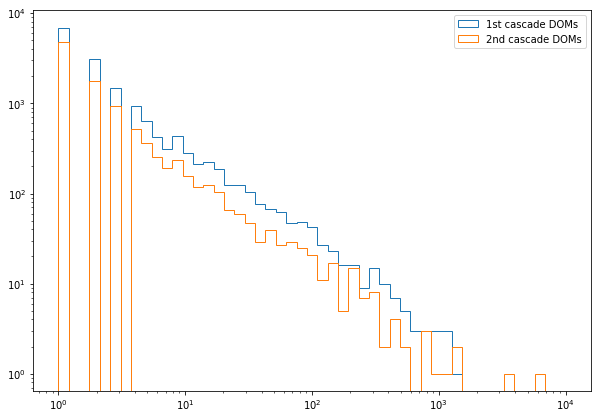

In [166]:
plt.figure(figsize=(10, 7))
binning = np.logspace(0, 4, 50)
# plt.hist(phot_dict['casc0_photons'], bins=binning, histtype='step', label="1st cascade")
plt.hist(phot_dict['casc0_photons_at_doms'], bins=binning, histtype='step', label="1st cascade DOMs")
# plt.hist(phot_dict['casc1_photons'], bins=binning, histtype='step', label="2nd cascade")
plt.hist(phot_dict['casc1_photons_at_doms'], bins=binning, histtype='step', label="2nd cascade DOMs")
plt.yscale('log')
plt.xscale('log')
plt.legend()

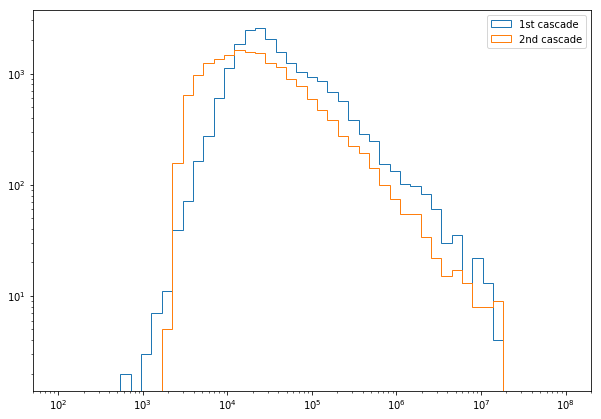

In [170]:
plt.figure(figsize=(10, 7))
binning = np.logspace(2, 8, 50)

plt.hist(phot_dict['casc0_photons'], bins=binning, histtype='step', label="1st cascade")
plt.hist(phot_dict['casc1_photons'], bins=binning, histtype='step', label="2nd cascade")
plt.yscale('log')
plt.xscale('log')
plt.legend()